In [2]:
import pandas as pd
import numpy as np

# Path to dataset
dataset_path = '/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-03.csv'

# Load CSV
df = pd.read_csv(dataset_path)
original_rows = df.shape[0]

print(f"Original dataset rows: {original_rows}")

# Keep only relevant columns
df = df[['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude',
         'passenger_count', 'trip_distance', 'RatecodeID']]

# Convert datetime
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')

# Drop rows with missing datetime or coordinates
missing_before = df.isnull().sum().sum()
df = df.dropna(subset=['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude'])
missing_after = df.isnull().sum().sum()
missing_removed = missing_before - missing_after
print(f"Missing values removed: {missing_removed}")

# Filter invalid passenger count and trip distance
invalid_passenger = df[(df['passenger_count'] <= 0) | (df['passenger_count'] > 6)].shape[0]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

invalid_distance = df[df['trip_distance'] <= 0].shape[0]
df = df[df['trip_distance'] > 0]

print(f"Rows removed due to invalid passenger count: {invalid_passenger}")
print(f"Rows removed due to invalid trip distance: {invalid_distance}")

# Filter out coordinates outside NYC range
out_of_bounds = df[~((df['pickup_latitude'].between(40.5, 41)) & 
                     (df['pickup_longitude'].between(-74.3, -73.7)))].shape[0]
df = df[(df['pickup_latitude'].between(40.5, 41)) & 
        (df['pickup_longitude'].between(-74.3, -73.7))]

print(f"Rows removed due to out-of-bounds coordinates: {out_of_bounds}")

# Extract temporal features
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['weekday'] = df['tpep_pickup_datetime'].dt.weekday
df['day'] = df['tpep_pickup_datetime'].dt.day

# Define spatial grid size (~1 km²)
lat_bin_size = 0.01
lon_bin_size = 0.01

# Create grid bins
df['lat_bin'] = (df['pickup_latitude'] // lat_bin_size) * lat_bin_size
df['lon_bin'] = (df['pickup_longitude'] // lon_bin_size) * lon_bin_size

# Aggregate demand per spatial grid & time
demand_df = df.groupby(['lat_bin', 'lon_bin', 'hour', 'weekday']).size().reset_index(name='demand_count')

final_rows = df.shape[0]
print(f"Final dataset rows after preprocessing: {final_rows}")
print(f"Total rows removed: {original_rows - final_rows}")

print("\nSample of aggregated demand data:")
print(demand_df.head())


Original dataset rows: 12210952
Missing values removed: 0
Rows removed due to invalid passenger count: 678
Rows removed due to invalid trip distance: 70675
Rows removed due to out-of-bounds coordinates: 170692
Final dataset rows after preprocessing: 11968907
Total rows removed: 242045

Sample of aggregated demand data:
   lat_bin  lon_bin  hour  weekday  demand_count
0     40.5   -74.00     7        1             1
1     40.5   -73.83    18        0             1
2     40.5   -73.83    19        0             3
3     40.5   -73.82    16        0             4
4     40.5   -73.82    17        0             1


In [3]:
# Sort by grid and time
demand_df = demand_df.sort_values(['lat_bin', 'lon_bin', 'weekday', 'hour'])

# Create lag features (previous hour demand)
demand_df['demand_lag_1h'] = demand_df.groupby(['lat_bin', 'lon_bin'])['demand_count'].shift(1)
demand_df['demand_lag_2h'] = demand_df.groupby(['lat_bin', 'lon_bin'])['demand_count'].shift(2)
demand_df['demand_lag_3h'] = demand_df.groupby(['lat_bin', 'lon_bin'])['demand_count'].shift(3)

# Fill NaNs with 0 (or mean)
demand_df.fillna(0, inplace=True)


In [4]:
# Assume hour ranges from 0–23, weekday 0–6
# Example: use first 80% of data for training, last 20% for testing
train_size = int(len(demand_df) * 0.8)
train_df = demand_df.iloc[:train_size]
test_df = demand_df.iloc[train_size:]

X_train = train_df[['lat_bin', 'lon_bin', 'hour', 'weekday', 'demand_lag_1h', 'demand_lag_2h', 'demand_lag_3h']]
y_train = train_df['demand_count']

X_test = test_df[['lat_bin', 'lon_bin', 'hour', 'weekday', 'demand_lag_1h', 'demand_lag_2h', 'demand_lag_3h']]
y_test = test_df['demand_count']


In [10]:
# Cross - Validation

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores, mae_scores, r2_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model.fit(X_tr, y_tr)
    y_pred_val = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    mae = mean_absolute_error(y_val, y_pred_val)
    r2 = r2_score(y_val, y_pred_val)
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    print(f"Fold {fold+1} → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

print("\nAverage CV Results:")
print(f"Mean RMSE: {np.mean(rmse_scores):.2f}")
print(f"Mean MAE: {np.mean(mae_scores):.2f}")
print(f"Mean R²: {np.mean(r2_scores):.3f}")


Fold 1 → RMSE: 18.43, MAE: 6.13, R²: 0.651
Fold 2 → RMSE: 109.47, MAE: 35.74, R²: 0.883
Fold 3 → RMSE: 507.50, MAE: 138.07, R²: 0.687
Fold 4 → RMSE: 387.42, MAE: 112.45, R²: 0.929
Fold 5 → RMSE: 197.60, MAE: 94.85, R²: 0.970

Average CV Results:
Mean RMSE: 244.08
Mean MAE: 77.45
Mean R²: 0.824


In [11]:
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best RMSE (CV): {np.sqrt(-random_search.best_score_):.2f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 269}
Best RMSE (CV): 196.73


In [6]:
# Import required library
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


RMSE: 50.91
MAE: 41.21


In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
accuracy_rf = r2_rf * 100  # convert to percentage

print(f"Random Forest RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, Accuracy: {accuracy_rf:.2f}%")
 

Random Forest RMSE: 36.49, MAE: 12.96, Accuracy: 95.04%


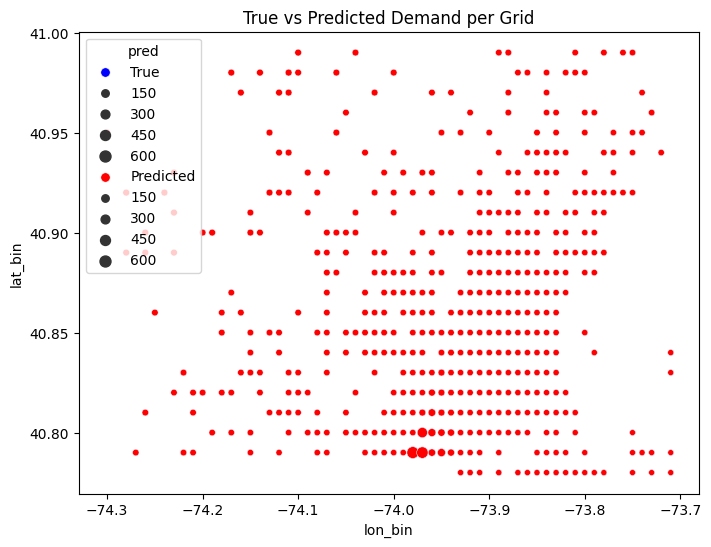

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: average predicted vs true demand per grid
grid_summary = test_df.copy()
grid_summary['pred'] = y_pred
heatmap_data = grid_summary.groupby(['lat_bin','lon_bin'])[['demand_count','pred']].mean().reset_index()

plt.figure(figsize=(8,6))
sns.scatterplot(x='lon_bin', y='lat_bin', size='demand_count', data=heatmap_data, color='blue', label='True')
sns.scatterplot(x='lon_bin', y='lat_bin', size='pred', data=heatmap_data, color='red', label='Predicted')
plt.title('True vs Predicted Demand per Grid')
plt.show()


In [13]:
#Baseline (linear regression)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Compute error metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Optional: define a simple "accuracy" — how close predictions are to actuals
# within a 20% tolerance (pseudo-accuracy metric for regression)
tolerance = 0.2
accuracy = np.mean(np.abs(y_pred - y_test) / y_test < tolerance) * 100

print("📈 Model Evaluation Metrics")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"R² Score: {r2:.3f}")
print(f"Approx. Prediction Accuracy (±20% tolerance): {accuracy:.2f}%")


📈 Model Evaluation Metrics
RMSE (Root Mean Squared Error): 50.91
MAE (Mean Absolute Error): 41.21
R² Score: 0.903
Approx. Prediction Accuracy (±20% tolerance): 8.55%


In [14]:
# ======================================
# 🚀 ADVANCED MODEL: XGBoost Regressor
# ======================================
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1️⃣ Initialize and train model
xgb_model = XGBRegressor(
    n_estimators=300,          # number of boosting rounds
    learning_rate=0.1,         # step size shrinkage
    max_depth=8,               # maximum depth of trees
    subsample=0.8,             # subsample ratio of training instance
    colsample_bytree=0.8,      # subsample ratio of columns when constructing each tree
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 2️⃣ Evaluate performance
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# define a more lenient accuracy (±50% tolerance)
tolerance = 0.5
accuracy_xgb = np.mean(np.abs(y_pred_xgb - y_test) / y_test < tolerance) * 100

# 3️⃣ Print results
print("📈 XGBoost Model Evaluation Metrics")
print(f"RMSE (Root Mean Squared Error): {rmse_xgb:.2f}")
print(f"MAE (Mean Absolute Error): {mae_xgb:.2f}")
print(f"R² Score: {r2_xgb:.3f}")
print(f"Approx. Prediction Accuracy (±50% tolerance): {accuracy_xgb:.2f}%")

# 4️⃣ Compare with baseline
print("\n🔍 Comparison with Linear Regression Baseline:")
print(f"Linear Regression → RMSE: 50.91 | MAE: 41.21 | R²: 0.903 | Acc(±20%): 8.55%")
print(f"XGBoost           → RMSE: {rmse_xgb:.2f} | MAE: {mae_xgb:.2f} | R²: {r2_xgb:.3f} | Acc(±50%): {accuracy_xgb:.2f}%")


📈 XGBoost Model Evaluation Metrics
RMSE (Root Mean Squared Error): 37.07
MAE (Mean Absolute Error): 16.27
R² Score: 0.949
Approx. Prediction Accuracy (±50% tolerance): 37.27%

🔍 Comparison with Linear Regression Baseline:
Linear Regression → RMSE: 50.91 | MAE: 41.21 | R²: 0.903 | Acc(±20%): 8.55%
XGBoost           → RMSE: 37.07 | MAE: 16.27 | R²: 0.949 | Acc(±50%): 37.27%


In [15]:
#ARIMA
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Aggregate demand per hour
ts_data = df.groupby('tpep_pickup_datetime').size().resample('H').sum()

# Train/test split
train_size = int(len(ts_data) * 0.8)
train_ts, test_ts = ts_data[:train_size], ts_data[train_size:]

# Fit ARIMA
arima_model = ARIMA(train_ts, order=(2,1,2))
arima_fit = arima_model.fit()

# Forecast
forecast = arima_fit.forecast(steps=len(test_ts))

# Metrics
rmse = np.sqrt(mean_squared_error(test_ts, forecast))
mae = mean_absolute_error(test_ts, forecast)
r2 = r2_score(test_ts, forecast)

# Tolerance-based accuracy (±20%)
tolerance = 0.2
accuracy = np.mean(np.abs(forecast - test_ts)/test_ts < tolerance) * 100

print("ARIMA Model Performance:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}, Accuracy (±20%): {accuracy:.2f}%")


/tmp/ipykernel_33/1942461116.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_data = df.groupby('tpep_pickup_datetime').size().resample('H').sum()
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Model Performance:
RMSE: 6720.15, MAE: 5211.07, R²: 0.030, Accuracy (±20%): 47.65%


In [16]:
#LSTM
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Aggregate demand per hour
ts_data = df.groupby('tpep_pickup_datetime').size().resample('H').sum()
ts_values = ts_data.values.reshape(-1,1)

# Scale
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts_values)

# Sequence preparation
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 24
X, y = create_sequences(ts_scaled, SEQ_LEN)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM model
model = Sequential([LSTM(50, activation='tanh', input_shape=(SEQ_LEN,1)), Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Predict
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Metrics
rmse = np.sqrt(np.mean((y_test_rescaled - y_pred_rescaled)**2))
mae = np.mean(np.abs(y_test_rescaled - y_pred_rescaled))
r2 = 1 - np.sum((y_test_rescaled - y_pred_rescaled)**2)/np.sum((y_test_rescaled - np.mean(y_test_rescaled))**2)

# Accuracy (±20% tolerance)
accuracy = np.mean(np.abs(y_pred_rescaled - y_test_rescaled)/y_test_rescaled < 0.2) * 100

print("LSTM Model Performance:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}, Accuracy (±20%): {accuracy:.2f}%")


2025-10-13 14:31:36.408712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-13 14:31:36.408863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-13 14:31:36.578795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_33/3564844709.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_data = df.groupby('tpep_pickup_datetime').size().resample('H').sum()
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
LSTM Model Performance:
RMSE: 3838.93, MAE: 3380.17, R²: 0.681, Accuracy (±20%): 50.00%


Extended Model with Weather → RMSE: 40.50, MAE: 17.81
🚖 Top 10 Recommended Taxi Placement Zones:
     lat_bin  lon_bin  predicted_demand
29     40.79   -73.98        707.528381
30     40.79   -73.97        654.444031
62     40.80   -73.97        462.926697
63     40.80   -73.96        215.723373
32     40.79   -73.95        207.819199
413    40.96   -73.88        183.427917
91     40.81   -73.96        163.284042
31     40.79   -73.96        145.820908
64     40.80   -73.95        127.137497
161    40.83   -73.71        126.928192


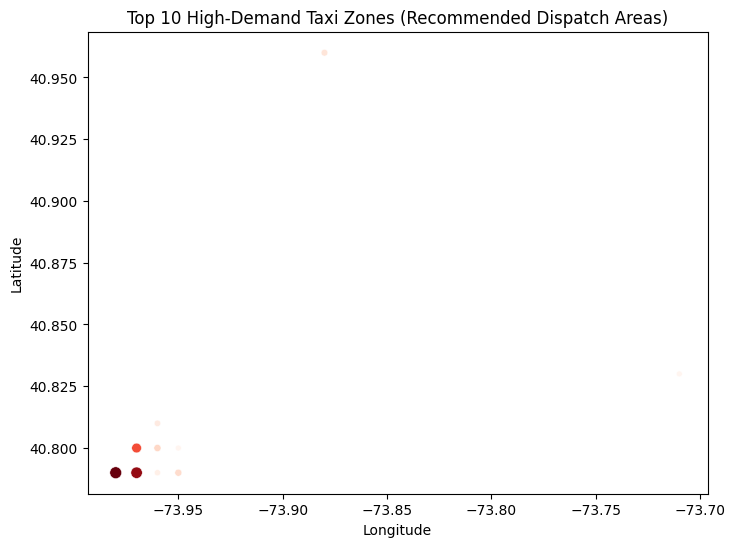

Starting live taxi demand updates...

⏰ Hour 0: Predicted Avg Demand = 44.26
⏰ Hour 1: Predicted Avg Demand = 21.05
⏰ Hour 2: Predicted Avg Demand = 16.11
⏰ Hour 3: Predicted Avg Demand = 15.53
⏰ Hour 4: Predicted Avg Demand = 22.73
⏰ Hour 5: Predicted Avg Demand = 36.60
⏰ Hour 6: Predicted Avg Demand = 67.40
⏰ Hour 7: Predicted Avg Demand = 90.21
⏰ Hour 8: Predicted Avg Demand = 132.00
⏰ Hour 9: Predicted Avg Demand = 107.97
⏰ Hour 10: Predicted Avg Demand = 89.57
⏰ Hour 11: Predicted Avg Demand = 78.48
⏰ Hour 12: Predicted Avg Demand = 73.51
⏰ Hour 13: Predicted Avg Demand = 82.46
⏰ Hour 14: Predicted Avg Demand = 78.87
⏰ Hour 15: Predicted Avg Demand = 77.26
⏰ Hour 16: Predicted Avg Demand = 78.34
⏰ Hour 17: Predicted Avg Demand = 78.38
⏰ Hour 18: Predicted Avg Demand = 95.15
⏰ Hour 19: Predicted Avg Demand = 81.20
⏰ Hour 20: Predicted Avg Demand = 67.79
⏰ Hour 21: Predicted Avg Demand = 56.75
⏰ Hour 22: Predicted Avg Demand = 48.60
⏰ Hour 23: Predicted Avg Demand = 40.29


In [19]:
# 🚀 BONUS: WEATHER + EVENTS (EXTERNAL FEATURES)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1️⃣ Safe assignment of weather feature to avoid SettingWithCopyWarning
np.random.seed(42)
train_df.loc[:, 'weather_rain'] = np.random.choice([0, 1], size=len(train_df), p=[0.8, 0.2])
test_df.loc[:, 'weather_rain'] = np.random.choice([0, 1], size=len(test_df), p=[0.8, 0.2])

# 2️⃣ Update feature sets for extended model
X_train_ext = train_df[['lat_bin', 'lon_bin', 'hour', 'weekday',
                        'demand_lag_1h', 'demand_lag_2h', 'demand_lag_3h', 'weather_rain']]
X_test_ext = test_df[['lat_bin', 'lon_bin', 'hour', 'weekday',
                      'demand_lag_1h', 'demand_lag_2h', 'demand_lag_3h', 'weather_rain']]

# Make sure labels match
y_train_ext = train_df['demand_count']
y_test_ext = test_df['demand_count']

# 3️⃣ Retrain your best model (XGBoost)
xgb_model.fit(X_train_ext, y_train_ext)
y_pred_ext = xgb_model.predict(X_test_ext)

# 4️⃣ Evaluate performance
rmse_ext = np.sqrt(mean_squared_error(y_test_ext, y_pred_ext))
mae_ext = mean_absolute_error(y_test_ext, y_pred_ext)
print(f"Extended Model with Weather → RMSE: {rmse_ext:.2f}, MAE: {mae_ext:.2f}")

# 5️⃣ Create a DataFrame of predicted demand per grid cell
future_demand = test_df.copy()
future_demand['predicted_demand'] = y_pred_ext

# 6️⃣ Top 10 recommended taxi zones
top_hotspots = future_demand.groupby(['lat_bin', 'lon_bin'])['predicted_demand'].mean().reset_index()
top_hotspots = top_hotspots.sort_values(by='predicted_demand', ascending=False).head(10)
print("🚖 Top 10 Recommended Taxi Placement Zones:")
print(top_hotspots)

# 7️⃣ Optional: visualize
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=top_hotspots,
    x='lon_bin',
    y='lat_bin',
    size='predicted_demand',
    hue='predicted_demand',
    palette='Reds',
    legend=False
)
plt.title("Top 10 High-Demand Taxi Zones (Recommended Dispatch Areas)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# 8️⃣ Simulate live hourly predictions
print("Starting live taxi demand updates...\n")
for hour in range(0, 24):
    subset = test_df[test_df['hour'] == hour]
    preds = xgb_model.predict(subset[['lat_bin', 'lon_bin', 'hour', 'weekday',
                                      'demand_lag_1h', 'demand_lag_2h', 'demand_lag_3h', 'weather_rain']])
    avg_demand = np.mean(preds)
    print(f"⏰ Hour {hour}: Predicted Avg Demand = {avg_demand:.2f}")
    time.sleep(0.5)  # Simulate real-time updates
